In [493]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import rosen
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

In [494]:
def get_all_points(x, y):
    result = []
    for row_x in x:
        val_x = row_x[0]
        for row_y in y:
            val_y = row_y[0]
            result.append([val_x, val_y])
    return torch.tensor(result)

def get_2D_array_column(array, column: int):
    result = []
    for row in array:
        val = row[column]
        result.append([val])
    return torch.tensor(result)

@np.vectorize
def apply_function_to_meshgrid(function, X, Y):
    return function([X, Y])

In [495]:
def calculate_target_function(train_X, dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    result = []
    for point in train_X:  # each row is a point
        val = rosen(point)
        result.append([val])

    return torch.tensor(result)

In [496]:
def BO_procedure(train_X, train_Y, bounds):
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    UCB = UpperConfidenceBound(gp, beta=10000, dtype=torch.float32)  # higher beta means more exploration (example: 10000)

    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20, dtype=torch.float32
    )

    candidate_z = calculate_target_function(candidate)
    print(f'    Candidate: ({candidate[0][0].numpy()}, {candidate[0][1].numpy()}, {candidate_z[0][0].numpy()})')

    new_X = torch.cat([train_X, candidate])
    new_Y = torch.cat([train_Y, candidate_z])

    return gp, new_X, new_Y, UCB

In [497]:
def plot(model, train_X, train_Y, bounds, UCB):
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    %matplotlib inline

    target_x = torch.linspace(bounds[0][0], bounds[1][0], 31).unsqueeze(1)
    target_y = torch.linspace(bounds[0][1], bounds[1][1], 31).unsqueeze(1)
    target_xy = get_all_points(target_x, target_y)
    target_z = calculate_target_function(target_xy)

    # # Initialize plot
    fig, ax = plt.subplots(1,3)

    # # no need for gradients
    with torch.no_grad():

        # plot target function (inclusion of noise decreases accuracy)
        X, Y = np.meshgrid(torch.linspace(bounds[0][0], bounds[1][0], 31), torch.linspace(bounds[0][1], bounds[1][1], 31))
        Z = apply_function_to_meshgrid(rosen, X, Y)
        levels = np.linspace(Z.min(), Z.max(), 25)
        ax[0].contourf(X, Y, Z, levels=levels)

        # compute posterior
        posterior = model.posterior(target_xy)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        pnt_x, pnt_y = get_2D_array_column(train_X, 0), get_2D_array_column(train_X, 1)
        ax[0].scatter(pnt_x, pnt_y, train_Y, color='k')
        # Plot posterior means as blue line
        posterior_mean = posterior.mean.cpu().numpy()
        levels = np.linspace(posterior_mean.min(), posterior_mean.max(), 25)
        ax[1].contourf(X, Y, posterior_mean.reshape(X.shape, order='F'), levels=levels)  # Fortran-like index order matches graph orientation
        # Shade between the lower and upper confidence bounds
        # UCB.forward()
        # ax[2].contourf(X, Y, UCB.forward(train_X))
        # ax.scatter(mean_x, mean_y, upper.cpu().numpy(), alpha=0.25, color='#87E911')
        # ax.scatter(mean_x, mean_y, lower.cpu().numpy(), alpha=0.25, color='#FF00BD')

    # ax.legend(['Target Function', 'Observed Data', 'Mean', 'Upper Confidence', 'Lower Confidence'])
    plt.tight_layout()

Iteration 1:
    Candidate: (-0.2844688296318054, 0.881950318813324, 65.81440734863281)
Iteration 2:
    Candidate: (-0.6720744967460632, -1.0, 213.53451538085938)
Iteration 3:
    Candidate: (0.6788349151611328, 0.8756307363510132, 17.310205459594727)
Iteration 4:
    Candidate: (-1.0, -0.8966520428657532, 363.7288818359375)
Iteration 5:
    Candidate: (0.01722121238708496, -0.015929996967315674, 0.9921843409538269)
Iteration 6:
    Candidate: (-1.0, 0.7474757432937622, 10.376850128173828)
Iteration 7:
    Candidate: (-1.0, -0.5485197901725769, 243.79136657714844)
Iteration 8:
    Candidate: (0.5617420673370361, 0.2453012466430664, 0.6856169700622559)
Iteration 9:
    Candidate: (-0.6705716848373413, -0.5710506439208984, 106.97712707519531)
Iteration 10:
    Candidate: (1.0, -1.0, 400.0)
Iteration 11:
    Candidate: (0.7047183513641357, -1.0, 224.0767059326172)
Iteration 12:
    Candidate: (0.1159636378288269, -1.0, 103.48910522460938)
Iteration 13:
    Candidate: (1.0, -0.35307234525

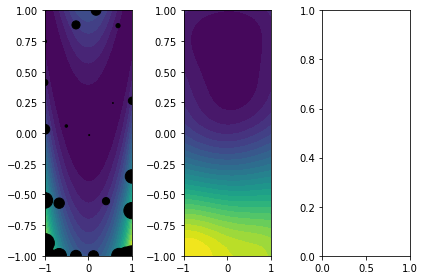

In [498]:
# use a GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = dtype=torch.float32
NUM_ITERATIONS = 25
BOUNDS = torch.tensor([[-1.0, -1.0], [1.0, 1.0]])

x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 1, dtype=DTYPE, device=DEVICE).unsqueeze(1)
y = torch.linspace(BOUNDS[0][1], BOUNDS[1][1], 1, dtype=DTYPE, device=DEVICE).unsqueeze(1)
train_XY = get_all_points(x, y)
train_Z = calculate_target_function(train_XY)

for i in range(NUM_ITERATIONS):
    print(f'Iteration {i + 1}:')
    model, train_XY, train_Z, UCB = BO_procedure(train_XY, train_Z, BOUNDS)

plot(model, train_XY, train_Z, BOUNDS, UCB)

In [499]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)

    Candidate: (1.0, -1.0, 400.0)


ValueError: too many values to unpack (expected 3)

    Candidate: (1.0, -1.0, 400.0)
tensor([[151.7935],
        [151.7927],
        [151.2955],
        [150.3753],
        [149.1176],
        [147.5993],
        [145.8847],
        [144.0313],
        [142.0990],
        [140.1472],
        [138.2262],
        [136.3735],
        [134.6144],
        [132.9657],
        [131.4377],
        [130.0344],
        [128.7546],
        [127.5928],
        [126.5422],
        [125.5970],
        [124.7551],
        [124.0191],
        [123.3955],
        [122.8892],
        [122.4956],
        [122.2034],
        [122.0046],
        [121.8998],
        [121.8996],
        [122.0213],
        [122.2819],
        [151.7138],
        [151.6785],
        [151.1398],
        [150.1708],
        [148.8572],
        [147.2773],
        [145.4984],
        [143.5827],
        [141.5925],
        [139.5882],
        [137.6206],
        [135.7280],
        [133.9374],
        [132.2672],
        [130.7288],
        [129.3274],
        [128.0614],
      

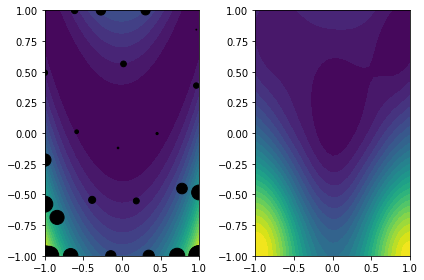

In [ ]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)

    Candidate: (0.5644246935844421, 0.5988889336585999, 8.04730224609375)
tensor([[332.9207],
        [327.5077],
        [316.3098],
        [300.8418],
        [282.7489],
        [263.4270],
        [243.8666],
        [224.6803],
        [206.2565],
        [188.8369],
        [172.5227],
        [157.3027],
        [143.1022],
        [129.8424],
        [117.4712],
        [105.9456],
        [ 95.2176],
        [ 85.2360],
        [ 75.9575],
        [ 67.3628],
        [ 59.4710],
        [ 52.3459],
        [ 46.0827],
        [ 40.7589],
        [ 36.3599],
        [ 32.8117],
        [ 30.0812],
        [ 28.2355],
        [ 27.4532],
        [ 27.9950],
        [ 30.1156],
        [323.4587],
        [317.0322],
        [304.9384],
        [288.6966],
        [270.0034],
        [250.3250],
        [230.6847],
        [211.6639],
        [193.5634],
        [176.5338],
        [160.6217],
        [145.8012],
        [132.0114],
        [119.1963],
        [107.3214],
      

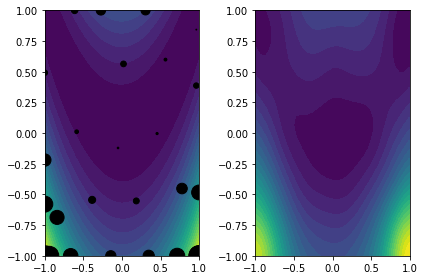

In [ ]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)

    Candidate: (-0.38907214999198914, 0.4518948793411255, 10.960612297058105)
tensor([[337.6845],
        [331.7642],
        [320.0000],
        [303.9416],
        [285.2708],
        [265.4191],
        [245.4011],
        [225.8376],
        [207.1104],
        [189.4449],
        [172.9217],
        [157.5114],
        [143.1248],
        [129.6755],
        [117.1109],
        [105.3916],
        [ 94.4748],
        [ 84.3140],
        [ 74.8685],
        [ 66.1195],
        [ 58.0836],
        [ 50.8201],
        [ 44.4184],
        [ 38.9523],
        [ 34.4109],
        [ 30.7292],
        [ 27.8846],
        [ 25.9518],
        [ 25.1143],
        [ 25.6328],
        [ 27.7599],
        [327.2914],
        [320.2972],
        [307.5931],
        [290.7343],
        [271.4587],
        [251.2702],
        [231.2142],
        [211.8744],
        [193.5374],
        [176.3315],
        [160.2799],
        [145.3360],
        [131.4234],
        [118.4781],
        [106.4648],
  

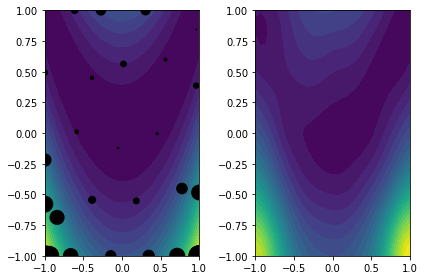

In [ ]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)